## Parallel, Multi-Objective BO in BoTorch with qEHVI and qParEGO

In this tutorial, we illustrate how to implement a simple multi-objective (MO) Bayesian Optimization (BO) closed loop in BoTorch.

We use the parallel ParEGO ($q$ParEGO) [1] and parallel Expected Hypervolume Improvement ($q$EHVI) [1]  acquisition functions to optimize a  synthetic Branin-Currin test function. The two objectives are

$$f^{(1)}(x_1\text{'}, x_2\text{'}) = (x_2\text{'} - \frac{5.1}{4 \pi^ 2} (x_1\text{'})^2 + \frac{5}{\pi} x_1\text{'} - r)^2 + 10 (1-\frac{1}{8 \pi}) \cos(x_1\text{'}) + 10$$

$$f^{(2)}(x_1, x_2) = \bigg[1 - \exp\bigg(-\frac{1} {(2x_2)}\bigg)\bigg] \frac{2300 x_1^3 + 1900x_1^2 + 2092 x_1 + 60}{100 x_1^3 + 500x_1^2 + 4x_1 + 20}$$

where $x_1, x_2 \in [0,1]$, $x_1\text{'} = 15x_1 - 5$, and $x_2\text{'} = 15x_2$ (parameter values can be found in `botorch/test_functions/multi_objective.py`).

Since botorch assumes a maximization of all objectives, we seek to find the pareto frontier, the set of optimal trade-offs where improving one metric means deteriorating another.

[1] [S. Daulton, M. Balandat, and E. Bakshy. Differentiable Expected Hypervolume Improvement for Parallel Multi-Objective Bayesian Optimization. Advances in Neural Information Processing Systems 33, 2020.](https://arxiv.org/abs/2006.05078)

### Set dtype and device
Note: $q$EHVI aggressively exploits parallel hardware and is much faster when run on a GPU. See [1] for details.

In [1]:
import torch
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

### Problem setup


In [2]:
from botorch.test_functions.multi_objective import BraninCurrin

problem = BraninCurrin(negate=True).to(**tkwargs)

#### Model initialization

We use a multi-output `SingleTaskGP` to model the two objectives with a homoskedastic Gaussian likelihood with an inferred noise level.

The models are initialized with $2(d+1)=6$ points drawn randomly from $[0,1]^2$.

In [3]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import unnormalize
from botorch.utils.sampling import draw_sobol_samples

def generate_initial_data(n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=n, seed=torch.randint(1000000, (1,)).item()).squeeze(0)
    train_obj = problem(train_x)
    return train_x, train_obj
    
def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

#### Define a helper function that performs the essential BO step for $q$EHVI
The helper function below initializes the $q$EHVI acquisition function, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. 

For this example, we'll use a small batch of $q=4$. Passing the keyword argument `sequential=True` to the function `optimize_acqf`specifies that candidates should be optimized in a sequential greedy fashion (see [1] for details why this is important). A simple initialization heuristic is used to select the 20 restart initial locations from a set of 1024 random points. Multi-start optimization of the acquisition function is performed using LBFGS-B with exact gradients computed via auto-differentiation.

**Reference Point**

$q$EHVI requires specifying a reference point, which is the lower bound on the objectives used for computing hypervolume. In this tutorial, we assume the reference point is known. In practice the reference point can be set 1) using domain knowledge to be slightly worse than the lower bound of objective values, where the lower bound is the minimum acceptable value of interest for each objective, or 2) using a dynamic reference point selection strategy.

**Partitioning the Non-dominated Space into disjoint rectangles**

$q$EHVI requires partitioning the non-dominated space into disjoint rectangles (see [1] for details). 

*Note:* `NondominatedPartitioning` *will be very slow when 1) there are a lot of points on the pareto frontier and 2) there are >3 objectives.*

In [4]:
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.utils.sampling import sample_simplex

BATCH_SIZE = 4
standard_bounds = torch.zeros(2, problem.dim, **tkwargs)
standard_bounds[1] = 1


def optimize_qehvi_and_get_observation(model, train_obj, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    partitioning = NondominatedPartitioning(ref_point=problem.ref_point, Y=train_obj)
    acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=problem.ref_point.tolist(),  # use known reference point 
        partitioning=partitioning,
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=20,
        raw_samples=1024,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200, "nonnegative": True},
        sequential=True,
    )
    # observe new values 
    new_x =  unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj = problem(new_x)
    return new_x, new_obj

#### Define a helper function that performs the essential BO step for $q$ParEGO
The helper function below similarly initializes $q$ParEGO, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. 

$q$ParEGO uses random augmented chebyshev scalarization with the `qExpectedImprovement` acquisition function. In the parallel setting ($q>1$), each candidate is optimized in sequential greedy fashion using a different random scalarization (see [1] for details).

To do this, we create a list of `qExpectedImprovement` acquisition functions, each with different random scalarization weights. The `optimize_acqf_list` method sequentially generates one candidate per acquisition function and conditions the next candidate (and acquisition function) on the previously selected pending candidates.

In [5]:
def optimize_qparego_and_get_observation(model, train_obj, sampler):
    """Samples a set of random weights for each candidate in the batch, performs sequential greedy optimization 
    of the qParEGO acquisition function, and returns a new candidate and observation."""
    acq_func_list = []
    for _ in range(BATCH_SIZE):
        weights = sample_simplex(problem.num_objectives, **tkwargs).squeeze()
        objective = GenericMCObjective(get_chebyshev_scalarization(weights=weights, Y=train_obj))
        acq_func = qExpectedImprovement(  # pyre-ignore: [28]
            model=model,
            objective=objective,
            best_f=objective(train_obj).max(),
            sampler=sampler,
        )
        acq_func_list.append(acq_func)
    # optimize
    candidates, _ = optimize_acqf_list(
        acq_function_list=acq_func_list,
        bounds=standard_bounds,
        num_restarts=20,
        raw_samples=1024,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values 
    new_x =  unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj = problem(new_x)
    return new_x, new_obj

### Perform Bayesian Optimization loop with $q$EHVI and $q$ParEGO
The Bayesian optimization "loop" for a batch size of $q$ simply iterates the following steps:
1. given a surrogate model, choose a batch of points $\{x_1, x_2, \ldots x_q\}$
2. observe $f(x)$ for each $x$ in the batch 
3. update the surrogate model. 


Just for illustration purposes, we run three trials each of which do `N_BATCH=25` rounds of optimization. The acquisition function is approximated using `MC_SAMPLES=128` samples.

*Note*: Running this may take a little while.

In [ ]:
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
import time

import warnings
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

N_TRIALS = 3
N_BATCH = 25
MC_SAMPLES = 128

verbose = False

hvs_qparego_all, hvs_qehvi_all, hvs_random_all = [], [], []

hv = Hypervolume(ref_point=problem.ref_point)

# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    torch.manual_seed(trial)
    
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    hvs_qparego, hvs_qehvi, hvs_random = [], [], []
    
    # call helper functions to generate initial training data and initialize model
    train_x_qparego, train_obj_qparego = generate_initial_data(n=6)
    mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego)
    
    train_x_qehvi, train_obj_qehvi = train_x_qparego, train_obj_qparego
    train_x_random, train_obj_random = train_x_qparego, train_obj_qparego
    # compute hypervolume 
    mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi)
    
    # compute pareto front
    pareto_mask = is_non_dominated(train_obj_qparego)
    pareto_y = train_obj_qparego[pareto_mask]
    # compute hypervolume
    
    volume = hv.compute(pareto_y)
    
    hvs_qparego.append(volume)
    hvs_qehvi.append(volume)
    hvs_random.append(volume)
    
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):    
        
        t0 = time.time()
        
        # fit the models
        fit_gpytorch_model(mll_qparego)
        fit_gpytorch_model(mll_qehvi)
        
        # define the qEI and qNEI acquisition modules using a QMC sampler
        qparego_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        qehvi_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        
        # optimize acquisition functions and get new observations
        new_x_qparego, new_obj_qparego = optimize_qparego_and_get_observation(
            model_qparego, train_obj_qparego, qparego_sampler
        )
        new_x_qehvi, new_obj_qehvi = optimize_qehvi_and_get_observation(
            model_qehvi, train_obj_qehvi, qehvi_sampler
        )
        new_x_random, new_obj_random = generate_initial_data(n=BATCH_SIZE)
                
        # update training points
        train_x_qparego = torch.cat([train_x_qparego, new_x_qparego])
        train_obj_qparego = torch.cat([train_obj_qparego, new_obj_qparego])

        train_x_qehvi = torch.cat([train_x_qehvi, new_x_qehvi])
        train_obj_qehvi = torch.cat([train_obj_qehvi, new_obj_qehvi])
    
        train_x_random = torch.cat([train_x_random, new_x_random])
        train_obj_random = torch.cat([train_obj_random, new_obj_random])
        

        # update progress
        for hvs_list, train_obj in zip(
            (hvs_random, hvs_qparego, hvs_qehvi), 
            (train_obj_random, train_obj_qparego, train_obj_qehvi),
        ):
            # compute pareto front
            pareto_mask = is_non_dominated(train_obj)
            pareto_y = train_obj[pareto_mask]
            # compute hypervolume
            volume = hv.compute(pareto_y)
            hvs_list.append(volume)

        # reinitialize the models so they are ready for fitting on next iteration
        # Note: we find improved performance from not warm starting the model hyperparameters
        # using the hyperparameters from the previous iteration
        mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego)
        mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi)
        
        t1 = time.time()
        
        if verbose:
            print(
                f"\nBatch {iteration:>2}: Hypervolume (random, qParEGO, qEHVI) = "
                f"({hvs_random[-1]:>4.2f}, {hvs_qparego[-1]:>4.2f}, {hvs_qehvi[-1]:>4.2f}), "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")
   
    hvs_qparego_all.append(hvs_qparego)
    hvs_qehvi_all.append(hvs_qehvi)
    hvs_random_all.append(hvs_random)

#### Plot the results
The plot below shows the a common metric of multi-objective optimization performance, the log hypervolume difference: the log difference between the hypervolume of the true pareto front and the hypervolume of the approximate pareto front identified by each algorithm. The log hypervolume difference is plotted at each step of the optimization for each of the algorithms. The confidence intervals represent the variance at that step in the optimization across the trial runs. The variance across optimization runs is quite high, so in order to get a better estimate of the average performance one would have to run a much larger number of trials `N_TRIALS` (we avoid this here to limit the runtime of this tutorial). 

The plot show that $q$EHVI vastly outperforms the $q$ParEGO and Sobol baselines and has very low variance.

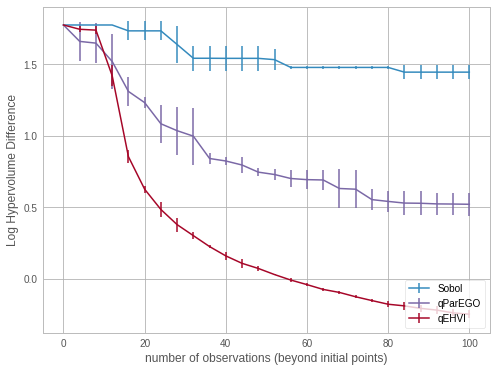

In [9]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


iters = np.arange(N_BATCH + 1) * BATCH_SIZE
log_hv_difference_qparego = np.log10(problem.max_hv - np.asarray(hvs_qparego_all))
log_hv_difference_qehvi = np.log10(problem.max_hv - np.asarray(hvs_qehvi_all))
log_hv_difference_rnd = np.log10(problem.max_hv - np.asarray(hvs_random_all))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, log_hv_difference_rnd.mean(axis=0), yerr=ci(log_hv_difference_rnd), label="Sobol", linewidth=1.5)
ax.errorbar(iters, log_hv_difference_qparego.mean(axis=0), yerr=ci(log_hv_difference_qparego), label="qParEGO", linewidth=1.5)
ax.errorbar(iters, log_hv_difference_qehvi.mean(axis=0), yerr=ci(log_hv_difference_qehvi), label="qEHVI", linewidth=1.5)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='Log Hypervolume Difference')
ax.legend(loc="lower right")

#### plot the observations colored by iteration

To examine optimization process from another perspective, we plot the collected observations under each algorithm where the color corresponds to the BO iteration at which the point was collected. The plot on the right for $q$EHVI shows that the $q$EHVI quickly identifies the pareto front and most of its evaluations are very close to the pareto front. $q$ParEGO also identifies has many observations close to the pareto front, but relies on optimizing random scalarizations, which is a less principled way of optimizing the pareto front compared to $q$EHVI, which explicitly attempts focuses on improving the pareto front. Sobol generates random points and has few points close to the pareto front

Text(0.5, 1.0, 'Iteration')

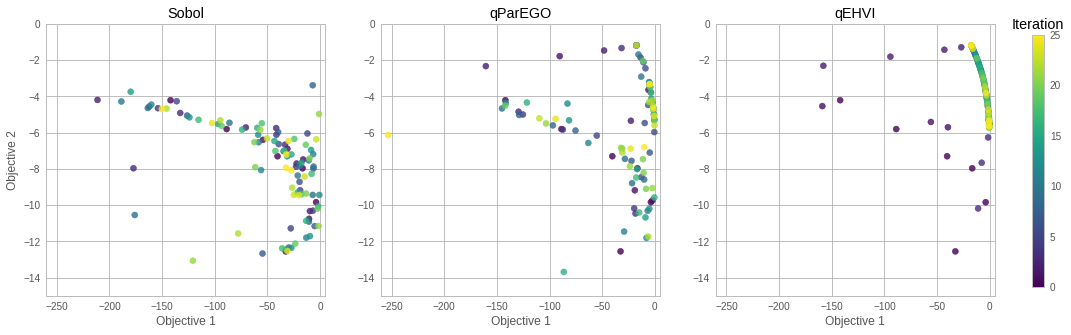

In [10]:
from matplotlib.cm import ScalarMappable
fig, axes = plt.subplots(1, 3, figsize=(17, 5))
algos = ["Sobol", "qParEGO", "qEHVI"]
cm = plt.cm.get_cmap('viridis')

batch_number = torch.cat([torch.zeros(6), torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]).numpy()
for i, train_obj in enumerate((train_obj_random, train_obj_qparego, train_obj_qehvi)):
    sc = axes[i].scatter(train_obj[:, 0].cpu().numpy(), train_obj[:,1].cpu().numpy(), c=batch_number, alpha=0.8)
    axes[i].set_title(algos[i])
    axes[i].set_xlabel("Objective 1")
    axes[i].set_xlim(-260, 5)
    axes[i].set_ylim(-15, 0)
axes[0].set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")